In [ ]:
!pip install seaborn

### File descriptions
- train.csv - Input features and target fare_amount values for the training set (about 55M rows).
- test.csv - Input features for the test set (about 10K rows). Your goal is to predict fare_amount for each row.

### Data fields
- ID
- key - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field. Required in your submission CSV. Not necessarily needed in the training set, but could be useful to simulate a 'submission file' while doing cross-validation within the training set.

### Features
- pickup_datetime - timestamp value indicating when the taxi ride started.
- pickup_longitude - float for longitude coordinate of where the taxi ride started.
- pickup_latitude - float for latitude coordinate of where the taxi ride started.
- dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
- dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
- passenger_count - integer indicating the number of passengers in the taxi ride.

In [1]:
##Import basic package
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Import train and test dataset
train = pd.read_csv("train.csv",nrows=10000000)
test = pd.read_csv("test.csv")
train.tail(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
9999990,2013-03-05 23:55:12.0000001,11.0,2013-03-05 23:55:12 UTC,-73.977005,40.758690,-73.982421,40.727640,2
9999991,2013-09-13 07:56:00.00000069,12.5,2013-09-13 07:56:00 UTC,-73.781852,40.644812,-73.779863,40.666525,1
9999992,2014-06-27 14:37:49.0000002,4.5,2014-06-27 14:37:49 UTC,-73.957567,40.779315,-73.951970,40.781583,2
9999993,2015-01-14 09:11:18.0000006,12.0,2015-01-14 09:11:18 UTC,-73.987755,40.738155,-73.972076,40.762775,1
9999994,2010-03-13 20:28:00.00000033,5.7,2010-03-13 20:28:00 UTC,-74.001518,40.730850,-73.991845,40.744305,2
9999995,2012-08-12 01:18:00.000000208,5.7,2012-08-12 01:18:00 UTC,-73.999464,40.728452,-73.993299,40.742100,2
9999996,2013-08-07 10:28:00.000000147,5.5,2013-08-07 10:28:00 UTC,-73.968467,40.759367,-73.964967,40.769027,1
9999997,2013-10-29 08:29:00.00000082,14.0,2013-10-29 08:29:00 UTC,-73.997952,40.733717,-73.973448,40.759122,5
9999998,2012-04-07 16:41:33.0000004,10.5,2012-04-07 16:41:33 UTC,-73.992700,40.752021,-73.964705,40.772849,1
9999999,2010-03-30 19:27:00.00000066,8.5,2010-03-30 19:27:00 UTC,-73.965390,40.768572,-73.998188,40.761073,1


In [3]:
train.shape

(10000000, 8)

In [4]:
test.shape

(9914, 7)

In [5]:
#check the missing values
train.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    69
dropoff_latitude     69
passenger_count       0
dtype: int64

In [6]:
#Since the missing values is just tiny part of the whole data, we drop them all
train = train.dropna()
train.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [7]:
#Check the target column (y)
train['fare_amount'].describe()

count    9.999931e+06
mean     1.133849e+01
std      9.799845e+00
min     -1.077500e+02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      1.273310e+03
Name: fare_amount, dtype: float64

In [8]:
#drop the negative amount since it doesn't make sense.
train = train.drop(train[train['fare_amount']<0].index, axis=0)
train.shape

(9999511, 8)

In [9]:
train['fare_amount'].describe()

count    9.999511e+06
mean     1.133935e+01
std      9.798654e+00
min      0.000000e+00
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      1.273310e+03
Name: fare_amount, dtype: float64

In [10]:
#drop the passenger amount which is larger than 5(each car can take 5 as maximum)
train['passenger_count'].describe()
train = train.drop(train[train['passenger_count']>5].index, axis = 0)

In [11]:
train['passenger_count'].describe()

count    9.787639e+06
mean     1.591179e+00
std      1.155953e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.000000e+00
Name: passenger_count, dtype: float64

In [12]:
#We can calulate the distance in a sphere when latitudes and longitudes are given by Haversine formula
def haversine_distance(lat1, long1, lat2, long2):
    data = [train, test]
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['H_Distance'] = d
    return d

In [13]:
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0        2.323260
1        2.425353
2        0.618628
3        1.961033
4        5.387301
5        3.222549
6        0.929601
7       21.540102
8        3.873962
9        1.099794
10       2.317685
11       4.819179
12       0.722670
13       1.675503
14       2.504032
15       5.115375
16       0.298838
17       2.531147
18       0.780444
19       0.427282
20       1.651946
21       1.969211
22       1.305441
23       1.901295
24       5.779720
25       1.121687
26      14.306540
27       9.427870
28       1.144529
29       4.696371
          ...    
9884    15.119293
9885     5.006239
9886     7.376754
9887     1.680721
9888     0.000000
9889     2.377723
9890     2.944581
9891     5.952839
9892     2.950361
9893     4.735375
9894     3.101361
9895     9.000325
9896     2.398161
9897     5.081663
9898     0.555287
9899     5.610506
9900     1.890608
9901     1.530118
9902     3.891525
9903     2.299316
9904    15.091263
9905     9.613797
9906     0.369506
9907     9.923999
9908     1

In [14]:
test['H_Distance'].head(10)

0     2.323260
1     2.425353
2     0.618628
3     1.961033
4     5.387301
5     3.222549
6     0.929601
7    21.540102
8     3.873962
9     1.099794
Name: H_Distance, dtype: float64

In [15]:
train['H_Distance'].head(10)

0    1.030764
1    8.450134
2    1.389525
3    2.799270
4    1.999157
5    3.787239
6    1.555807
7    4.155444
8    1.253232
9    2.849627
Name: H_Distance, dtype: float64

In [16]:
train.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1,3.787239
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1,1.555807
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1,4.155444
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1,1.253232
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2,2.849627


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9787639 entries, 0 to 9999999
Data columns (total 9 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
H_Distance           float64
dtypes: float64(6), int64(1), object(2)
memory usage: 746.7+ MB


In [18]:
#latitude should between -90 to 90; Longitude should between -180 to 180. pick those are in this range.
train = train.drop(train[(train['pickup_latitude']<-90)|(train['pickup_latitude']>90)].index, axis=0)
train = train.drop(train[(train['pickup_longitude']<-180)|(train['pickup_longitude']>180)].index, axis=0)
train = train.drop(train[(train['dropoff_latitude']<-90)|(train['dropoff_latitude']>90)].index, axis=0)
train = train.drop(train[(train['dropoff_longitude']<-180)|(train['dropoff_longitude']>180)].index, axis=0)

In [19]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157


In [20]:
min(train.pickup_longitude.min(), train.dropoff_longitude.min()), \
max(train.pickup_longitude.max(), train.dropoff_longitude.max())

(-173.342034, 154.10075600000002)

In [21]:
# minimum and maximum latitude train
min(train.pickup_latitude.min(), train.dropoff_latitude.min()), \
max(train.pickup_latitude.max(), train.dropoff_latitude.max())

(-74.824164, 89.742163)

In [22]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [23]:
print('Old size: %d' % len(train))
train = train[select_within_boundingbox(train, BB)]
print('New size: %d' % len(train))

Old size: 9787190
New size: 9579772


In [24]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

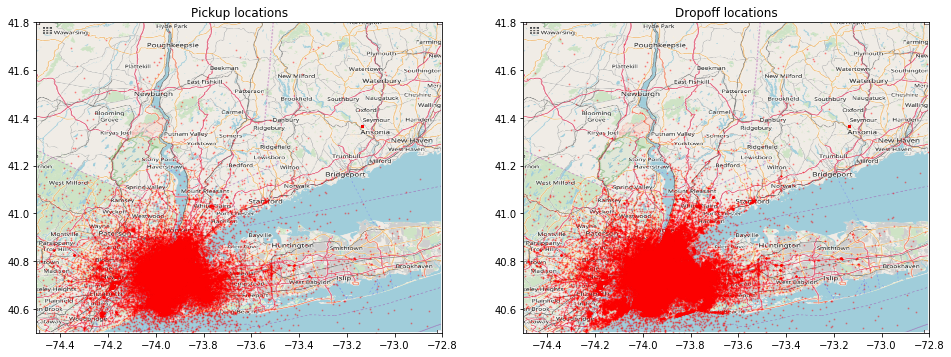

In [25]:
plot_on_map(train, BB, nyc_map, s=1, alpha=0.3)

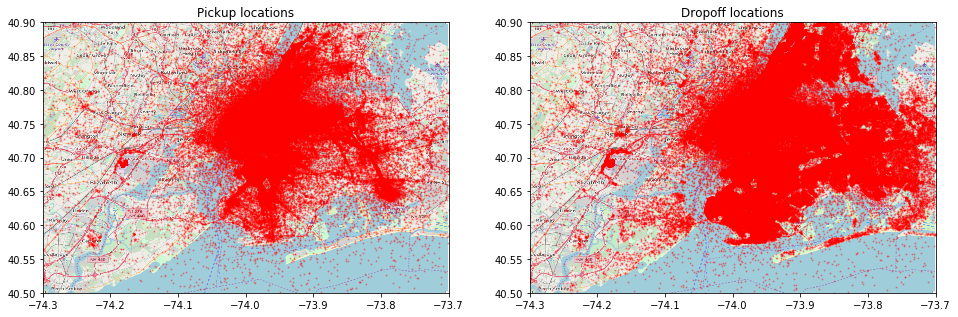

In [26]:
# plot training data on map zoomed in
plot_on_map(train, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

In [108]:
#Import train and test dataset
train = pd.read_csv("train.csv",nrows=10000000)
test = pd.read_csv("test.csv")
train.tail(10)

#Since the missing values is just tiny part of the whole data, we drop them all
train = train.dropna()

#drop the negative amount since it doesn't make sense.
train = train.drop(train[train['fare_amount']<0].index, axis=0)

#drop the passenger amount which is larger than 5(each car can take 5 as maximum)
train = train.drop(train[train['passenger_count']>5].index, axis = 0)

#We can calulate the distance in a sphere when latitudes and longitudes are given by Haversine formula
def haversine_distance(lat1, long1, lat2, long2):
    data = [train]
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['H_Distance'] = d
    return d

#latitude should between -90 to 90; Longitude should between -180 to 180. pick those are in this range.
train = train.drop(train[(train['pickup_latitude']<-90)|(train['pickup_latitude']>90)].index, axis=0)
train = train.drop(train[(train['pickup_longitude']<-180)|(train['pickup_longitude']>180)].index, axis=0)
train = train.drop(train[(train['dropoff_latitude']<-90)|(train['dropoff_latitude']>90)].index, axis=0)
train = train.drop(train[(train['dropoff_longitude']<-180)|(train['dropoff_longitude']>180)].index, axis=0)

scale_l = [-74.1,-73.7, 40.55, 40.90]
n = 10
train = train.drop(train[(train['pickup_latitude']<scale_l[2])|(train['pickup_latitude']>scale_l[3])].index, axis=0)
train = train.drop(train[(train['pickup_longitude']<scale_l[0])|(train['pickup_longitude']>scale_l[1])].index, axis=0)
train = train.drop(train[(train['dropoff_latitude']<scale_l[2])|(train['dropoff_latitude']>scale_l[3])].index, axis=0)
train = train.drop(train[(train['dropoff_longitude']<scale_l[0])|(train['dropoff_longitude']>scale_l[1])].index, axis=0)
train['pickup_longitude_range'] = pd.cut(train['pickup_longitude'], n)
train['pickup_latitude_range'] = pd.cut(train['pickup_latitude'], n)
train['dropoff_longitude_range'] = pd.cut(train['dropoff_longitude'], n)
train['dropoff_latitude_range'] = pd.cut(train['dropoff_latitude'], n)

In [110]:
train.dtypes

key                                     object
fare_amount                            float64
pickup_datetime            datetime64[ns, UTC]
pickup_longitude                       float64
pickup_latitude                        float64
dropoff_longitude                      float64
dropoff_latitude                       float64
passenger_count                          int64
H_Distance                             float64
fare_per_mile                          float64
Year                                     int64
Hour                                     int64
pickup_longitude_range                category
pickup_latitude_range                 category
dropoff_longitude_range               category
dropoff_latitude_range                category
dtype: object

In [111]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,fare_per_mile,Year,Hour,pickup_longitude_range,pickup_latitude_range,dropoff_longitude_range,dropoff_latitude_range
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,4.365694,2009,17,"(-73.86, -73.82]","(40.69, 40.725]","(-73.86, -73.82]","(40.691, 40.726]"
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,1.999968,2010,16,"(-74.02, -73.98]","(40.69, 40.725]","(-73.98, -73.94]","(40.761, 40.795]"
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,4.102121,2011,0,"(-74.02, -73.98]","(40.76, 40.795]","(-74.02, -73.98]","(40.726, 40.761]"
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2.750717,2012,4,"(-74.02, -73.98]","(40.725, 40.76]","(-74.02, -73.98]","(40.726, 40.761]"
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,2.651118,2010,7,"(-73.98, -73.94]","(40.76, 40.795]","(-73.98, -73.94]","(40.761, 40.795]"


### Removing datapoints in water

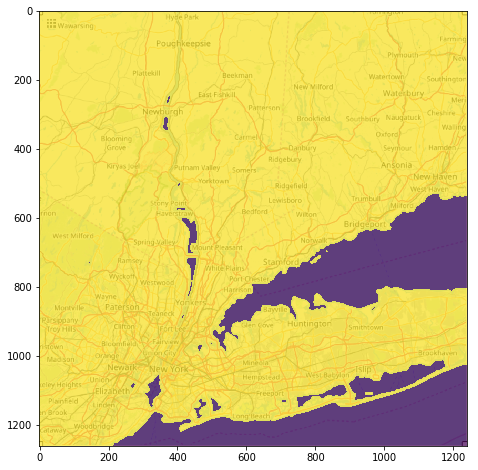

In [27]:
# read nyc mask and turn into boolean map with
# land = True, water = False
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9

plt.figure(figsize=(8,8))
plt.imshow(nyc_map, zorder=0)
plt.imshow(nyc_mask, zorder=1, alpha=0.7); # note: True is show in yellow, False in purple.

In [28]:
# translate longitude/latitude coordinate into image xy coordinate
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

In [29]:
pickup_x, pickup_y = lonlat_to_xy(train.pickup_longitude, train.pickup_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(train.dropoff_longitude, train.dropoff_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)

In [30]:
idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
print("Number of trips in water: {}".format(np.sum(~idx)))

Number of trips in water: 2014


In [31]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

In [32]:
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    # return only datapoints on land
    return df[idx]

In [33]:
print('Old size: %d' % len(train))
train = remove_datapoints_from_water(train)                                    
print('New size: %d' % len(train))

Old size: 9579772
New size: 9577758


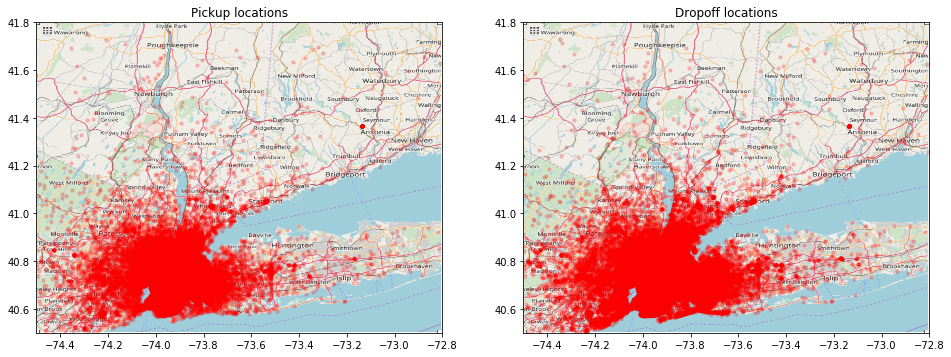

In [34]:
#plot data without those in waters
plot_on_map(train, BB, nyc_map)

In [35]:
train['fare_per_mile'] = train.fare_amount / train.H_Distance
train.fare_per_mile.describe()

count    9.577724e+06
mean              inf
std               NaN
min      0.000000e+00
25%      2.972855e+00
50%      3.836384e+00
75%      5.104431e+00
max               inf
Name: fare_per_mile, dtype: float64

In [36]:
# Drop the distance which under 0.1
train=train.drop(train[train['H_Distance']<0.1].index,axis=0)
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,fare_per_mile
count,9.419375e+06,9.419375e+06,9.419375e+06,9.419375e+06,9.419375e+06,9.419375e+06,9.419375e+06,9.419375e+06
mean,1.127587e+01,-7.397561e+01,4.075103e+01,-7.397474e+01,4.075140e+01,1.591606e+00,3.379779e+00,4.553007e+00
std,9.433992e+00,3.538455e-02,2.761435e-02,3.444440e-02,3.108275e-02,1.155337e+00,3.772113e+00,6.417905e+00
min,0.000000e+00,-7.449367e+01,4.050386e+01,-7.449991e+01,4.050003e+01,0.000000e+00,1.000057e-01,0.000000e+00
25%,6.000000e+00,-7.399230e+01,4.073661e+01,-7.399159e+01,4.073566e+01,1.000000e+00,1.291803e+00,2.959081e+00
50%,8.500000e+00,-7.398214e+01,4.075338e+01,-7.398065e+01,4.075391e+01,1.000000e+00,2.188817e+00,3.805143e+00
75%,1.250000e+01,-7.396854e+01,4.076755e+01,-7.396563e+01,4.076841e+01,2.000000e+00,3.954573e+00,5.015289e+00
max,9.520000e+02,-7.280843e+01,4.175844e+01,-7.280626e+01,4.173163e+01,5.000000e+00,1.438347e+02,2.369022e+03


In [44]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

In [45]:
import datetime
train['Year'] = train['pickup_datetime'].dt.year
train['Hour'] = train['pickup_datetime'].dt.hour
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,fare_per_mile,Year,Hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,4.365694,2009,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,1.999968,2010,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,4.102121,2011,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2.750717,2012,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,2.651118,2010,7


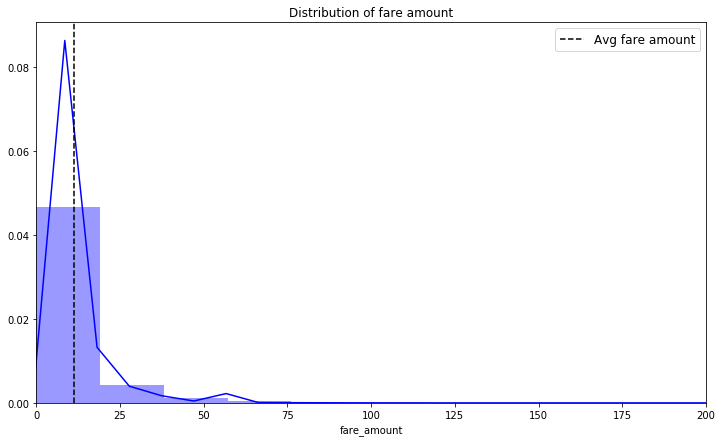

In [64]:
plt.figure(figsize = (12,7))
sns.distplot(train["fare_amount"],color = "b")
plt.axvline(train["fare_amount"].mean(),color = "k",
            linestyle = "dashed",label = "Avg fare amount")
plt.xlim(0,200)
plt.title("Distribution of fare amount")
plt.legend(loc = "best",prop = {"size" : 12})
plt.show()

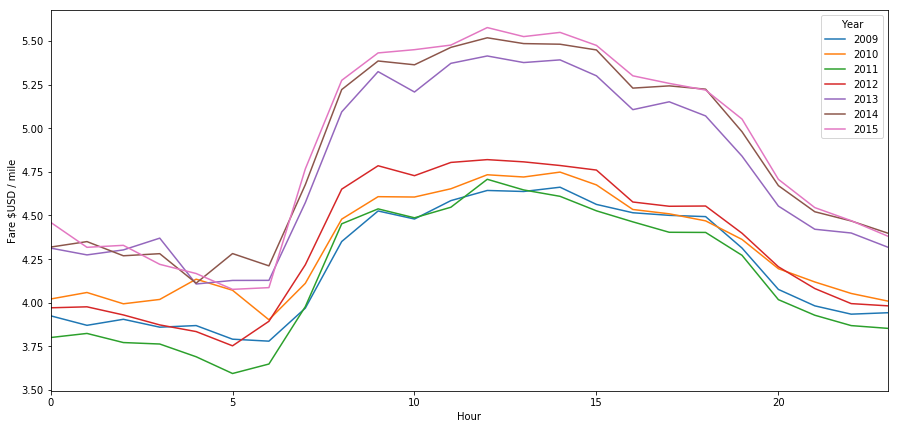

In [47]:
train_farepermile=train[['fare_per_mile','Year','Hour']]
fig, ax = plt.subplots(figsize=(15,7))
train_farepermile.groupby(['Hour','Year']).mean()['fare_per_mile'].unstack().plot(ax=ax)
plt.ylabel('Fare $USD / mile');

Text(0, 0.5, 'Frequency')

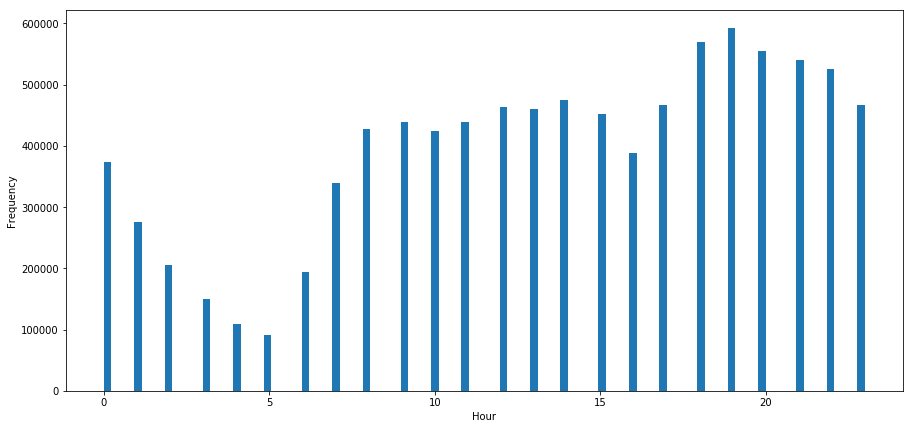

In [48]:
plt.figure(figsize=(15,7))
plt.hist(train['Hour'], bins=100)
plt.xlabel('Hour')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

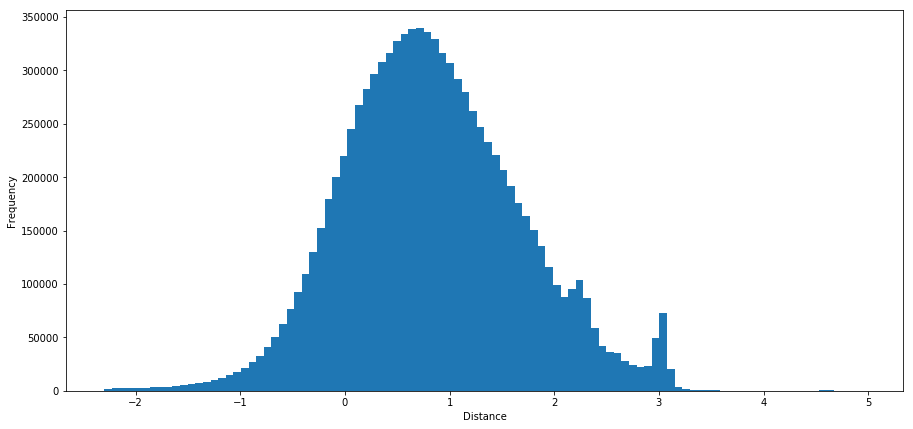

In [69]:
import numpy as np
plt.figure(figsize=(15,7))
plt.hist(np.log(train['H_Distance']), bins = 100)
plt.xlabel('Distance')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

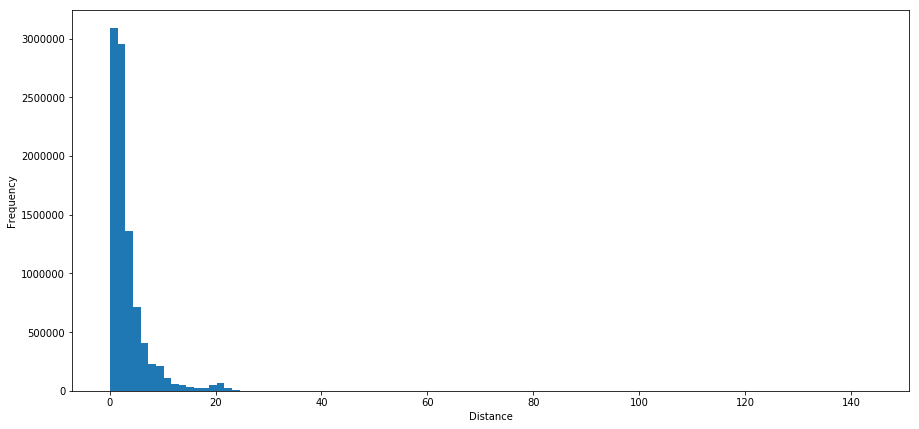

In [70]:
plt.figure(figsize=(15,7))
plt.hist(train['H_Distance'], bins = 100)
plt.xlabel('Distance')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

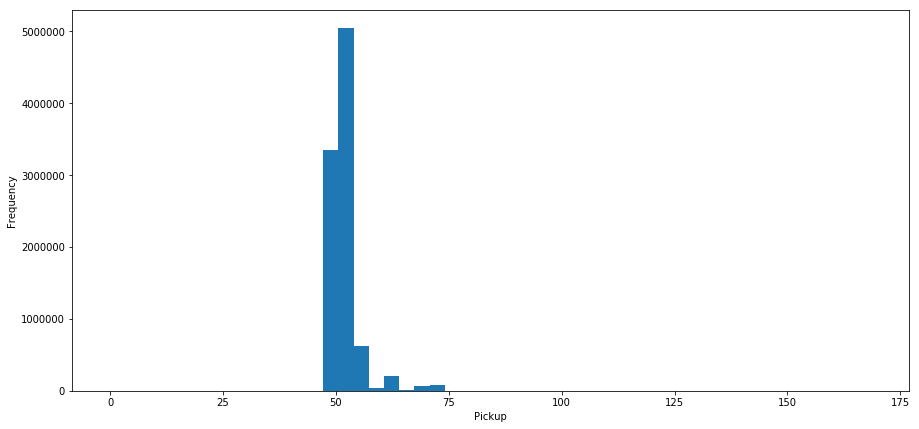

In [97]:
plt.figure(figsize=(15,7))
plt.hist((train['pickup_longitude']-train['pickup_longitude'].min())*100, bins = 50)
plt.xlabel('Pickup')
plt.ylabel('Frequency')